This is a notebook to explore the trained ANN saved by `create_and_train.py`

In [1]:
try:
    import cPickle as pickle
except:
    import pickle
import glob
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import lasagne
from lasagne import layers
from lasagne import nonlinearities
from nolearn.lasagne import NeuralNet, TrainSplit
from sklearn import preprocessing
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error

from create_and_train import EarlyStopping
from constants import Y_COLUMNS

%matplotlib inline

In [63]:
def gen_train_test(params='default', results='default'):
    """
    Re-create the scaled training (includes validation) and test sets that
    were used in training the networks.  This function assumes 
    there are four parameters that are varied in your input layer and that
    your results file contains two extra columns: 'light_aromatic_C-C', and
    'light_aromatic_methoxyl'.
    
    Parameters
    ----------
    params   : str, optional 
               the relative or absolute path to the text file of parameters
               used in the input layer of the network
    results  : str, optional
               the relative or absolute path to the text file of expected values
               for the output layer of the network
    
    Returns
    -------
    x_train  : numpy.ndarray
               the scaled training data used for the input layer of the network
               (standardized to have zero mean and unit variance).  This array
               is split into a training and a validation set by nolearn    
    x_test   : numpy.ndarray
               scaled data you can use as a test set that the network has never
               seen before.  It is 20% of the data in params.    
    y_train  : numpy.ndarray
               the scaled training data used for the output layer of the network
               (standardized to have zero mean and unit variance).  
    y_test   : numpy.ndarray
               scaled expected output values that the network has not seen
               before to use with x_test.
    x_scaler : sklearn.preprocessing.data.StandardScaler
               a scaler that can be used later to scale new data or recover
               the original values (x_scaler.transform(),
               x_scaler.inverse_transform())
    y_scaler : sklearn.preprocessing.data.StandardScaler
               a scaler that can be used later to scale new data or recover
               the original values (y_scaler.transform(),
               y_scaler.inverse_transform())
    """
    # use the same random seed that was used initially
    np.random.seed(6509)
    
    # set the paths to appropriate files
    if params == 'default':
        params = '../../parameters_250000.txt'
    if results == 'default':
        results = '../../results.txt'
        
    # Read the training data for the neural network
    # Default input data is 250000x4 and output data is 250000x32
    X = pd.read_csv(params, sep=' ')
    Y = pd.read_csv(results, sep=' ', index_col=False)
    # These functional groups do not exist in my model
    Y = Y.drop(['light_aromatic_C-C', 'light_aromatic_methoxyl'], axis=1)
    y_columns = Y.columns.values

    X = X.values.astype(np.float32)
    Y = Y.values.astype(np.float32)

    # Shuffle the dataset (because x parameters are varied in a structured way)
    combined = np.concatenate((X, Y), axis=1)
    np.random.shuffle(combined)

    # Separate the data into training (with included validation) and test sets.
    # (Validation set is separated from the training set by nolearn)
    test_fraction = 0.2
    training = combined[:-int(test_fraction * combined.shape[0]), :]
    test = combined[-int(test_fraction * combined.shape[0]):, :]

    x_train = training[:, :4]
    y_train = training[:, 4:]
    x_test = test[:, :4]
    y_test = test[:, 4:]
    
    # Standardize input & output to have zero mean and unit variance
    # x_scaler.transform() can be used later to transform any new data
    # x_scaler.inverse_transform() can be used to get the original data back
    x_scaler = preprocessing.StandardScaler().fit(x_train)
    x_train = x_scaler.transform(x_train)
    x_test = x_scaler.transform(x_test)
    y_scaler = preprocessing.StandardScaler().fit(y_train)
    y_train = y_scaler.transform(y_train)
    y_test = y_scaler.transform(y_test)
    
    return x_train, x_test, y_train, y_test, x_scaler, y_scaler
    
    
def load_nets(myglob):
    """  
    Load a dictionary of trained neural networks with filenames 
    matching a unix-style pattern.  Filenames of networks trained for
    individual output measures should be named, 
    `OutputCol-NameOfOutputCol_net.pkl` and filenames for a network trained
    for the complete set of output measures should be `full_net.pkl`.
    
    Parameters
    ----------
    glob    : str
              the unix-style pattern (including abs or rel path) for the 
              filenames you want to load.  Wildcards accepted.
    
    Returns
    -------
    nets  : dict
            a dictionary with the trained networks.  Keys are the columns
            from y_train that the network is trained on.
    """
    files_list = glob.glob(myglob)
    nets = {}
    
# UNCOMMENT THIS WHEN USING THE FINAL SET OF RESULTS    
#     if [x for x in files_list if 'full' in x]:
#         with open('full_net.pkl', 'rb') as pkl:
#             nets['all'] = pickle.load(pkl)[0]
#     else:
#         for filename in files_list:
#             output_col = int(filename.split('/')[-1].split('-')[0])
#             with open(filename, 'rb') as pkl:
#                 nets[output_col] = pickle.load(pkl)[0]
    if [x for x in files_list if 'ann_objects_updated' in x]:
        with open(files_list[0], 'rb') as pkl:
            nets['all'] = pickle.load(pkl)[0]
    else:
        for filename in files_list:
            output_col = int(filename.split('/')[-1].split('-')[1])
            with open(filename, 'rb') as pkl:
                nets[output_col] = pickle.load(pkl)[0]
    
    return nets
    
    
def plot_one_learning_curve(output_col, nets):
    """
    Plot the learning curves for a single output measure.
    
    Parameters
    ----------
    output_col : int or str
                 the key of the network in 'nets' that you want to plot
    nets       : a dictionary with the trained networks.  Keys are the columns
                 from y_train that the network is trained on.
    """
    if output_col == 'all':
        title = 'Full Network'
    else:
        title = Y_COLUMNS[output_col]
    net = nets[output_col]

    train_loss = np.array([i["train_loss"] for i in net.train_history_])
    valid_loss = np.array([i["valid_loss"] for i in net.train_history_])

    plt.figure()
    plt.plot(train_loss, label='train')
    plt.plot(valid_loss, label='validation')
    plt.legend(loc=0)
    plt.xlabel('Epoch')
    plt.ylabel('Loss (MSE)')
    plt.yscale('log')
    plt.title('%s Learning Curves' % title)
    
def pplot_one_output(net, x_train, y_train, x_test, y_test, output_col,
                             title, ub=None):
    """
    Make a parity plot for the training (blue), validation (green),
    and test (red) set predictions of a specific output measure.
    
    Parameters
    ----------
    net
    
    x_train    : numpy.ndarray
                 the scaled training data used for the input layer of the 
                 network (standardized to have zero mean and unit variance)
    x_test     : numpy.ndarray
                 scaled data you can use as a test set that the network has
                 never seen before
    y_train    : numpy.ndarray
                 the scaled training data used for the output layer of the 
                 network (standardized to have zero mean and unit variance)  
    y_test     : numpy.ndarray
                 scaled expected output values that the network has not seen
                 before to use with x_test
    output_col : int
                 the column of the output measure in y_train to plot
    title      : string
                 the name of the output measure being plotted
    ub         : int
                 the number of points you would like to include in plot
    
    Returns
    -------
    None
    """
    # get the same train/test split that was used in setting up the network
    Xt, Xv, yt, yv = net.train_split(x_train, y_train[:, output_col], net)
    # calculate the values predicted by the network
    y_pred_train = net.predict(Xt)
    y_pred_valid = net.predict(Xv)
    y_pred_test = net.predict(x_test)
    
    r2_train = round(r2_score(yt[:], y_pred_train[:]), 4)
    r2_valid = round(r2_score(yv[:], y_pred_valid[:]), 4)
    r2_test = round(r2_score(y_test[:, output_col], y_pred_test[:]), 4)
    
    if ub is None:
        ub = y_pred_train.shape[0]

    # Parity plot of the training data
    ax[output_col].plot([np.min(yt[:ub]), np.max(yt[:ub])],
                        [np.min(yt[:ub]), np.max(yt[:ub])], c='black')
    ax[output_col].scatter(y_pred_train[:ub].flatten(),
                           yt[:ub].flatten(),
                           s=0.1, alpha=0.16,
                           c='b', marker='x', label='train')
    ax[output_col].scatter(y_pred_valid[:ub].flatten(),
                           yv[:ub].flatten(),
                           s=0.1, alpha=0.16,
                           c='g', marker='x', label='valid')
    ax[output_col].scatter(y_pred_test[:ub].flatten(),
                           y_test[:ub, output_col].flatten(),
                           s=0.1, alpha=0.16,
                           c='r', marker='x', label='test')
    ax[output_col].set_title('%s - r**2=%s, %s, %s' % 
                             (title, r2_train, r2_valid, r2_test))
    return None


def calc_r_squared(nets, x_train, y_train):
    """
    Calculate the r squared value for the training, validation, and test sets.
    """
    r_squared = {}
    
    for key in nets:
        net = nets[key]
        title = Y_COLUMNS[key]
        # get the same train/test split that was used in setting up the network
        Xt, Xv, yt, yv = net.train_split(x_train, y_train[:, key], net)
        # calculate the values predicted by the network
        y_pred_train = net.predict(Xt)
        y_pred_valid = net.predict(Xv)
        y_pred_test = net.predict(x_test)
        # calculate r**2 values
        r2_train = round(r2_score(yt[:], y_pred_train[:]), 5)
        r2_valid = round(r2_score(yv[:], y_pred_valid[:]), 5)
        r2_test= round(r2_score(y_test[:, key], y_pred_test[:]), 5)
        r_squared[title] = r2_train, r2_valid, r2_test
        
    return r_squared

In [3]:
x_train, x_test, y_train, y_test, x_scaler, y_scaler = gen_train_test()

nets = load_nets('../updated_ann-*')
full_net = load_nets('trained_networks/ann_objects_updated.pkl')

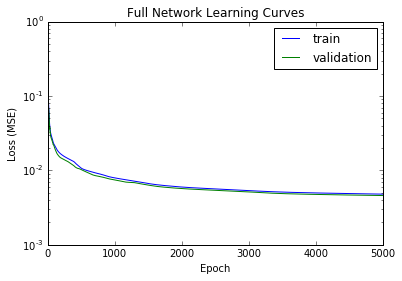

In [29]:
plot_one_learning_curve('all', full_net)

/usr/local/lib/python2.7/site-packages/matplotlib/pyplot.py:516: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


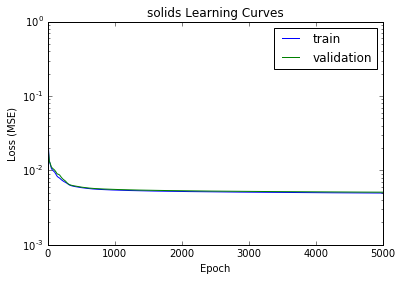

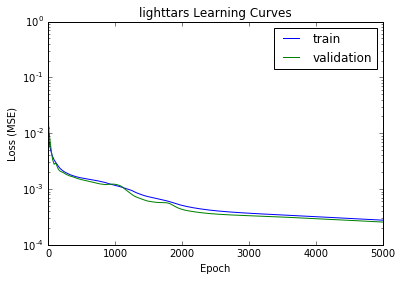

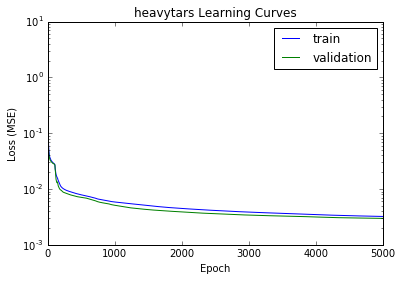

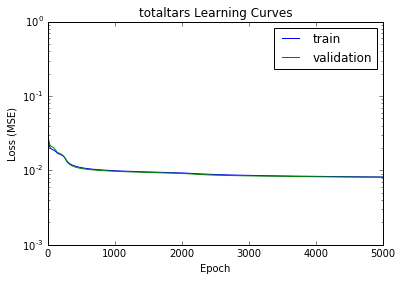

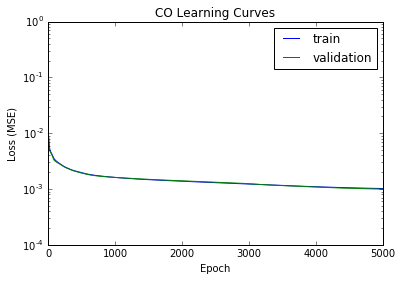

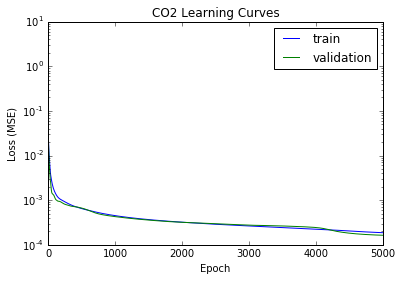

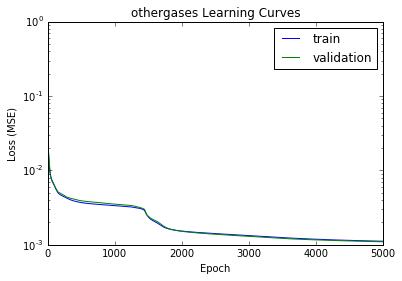

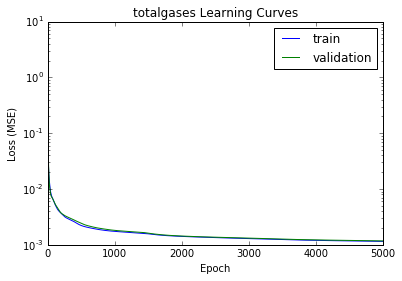

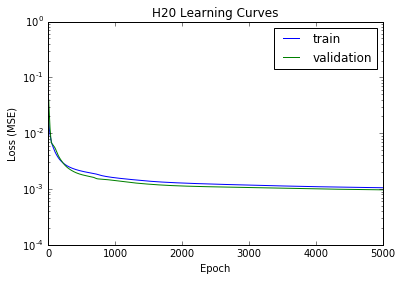

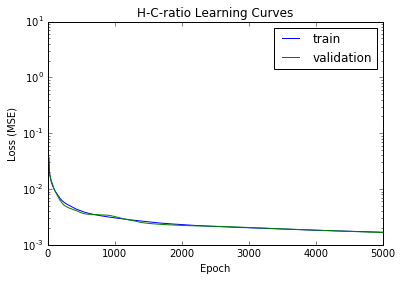

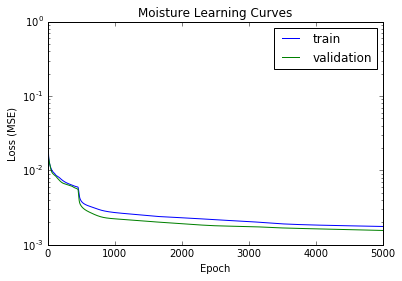

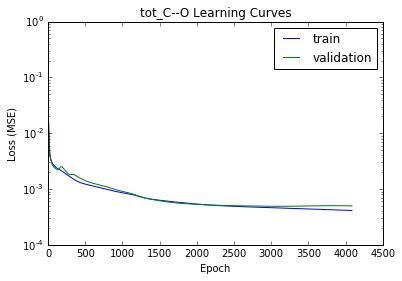

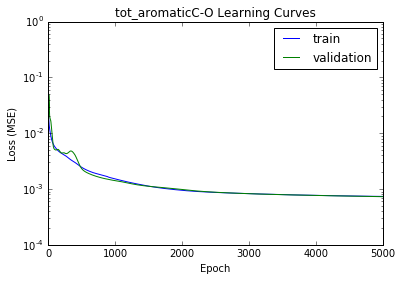

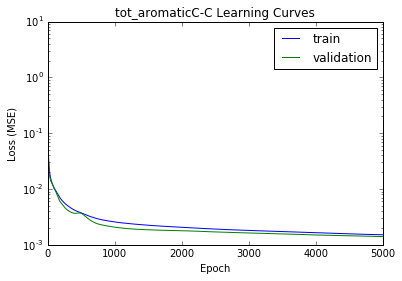

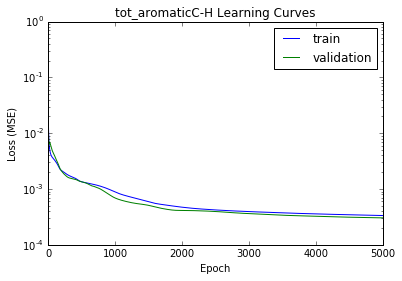

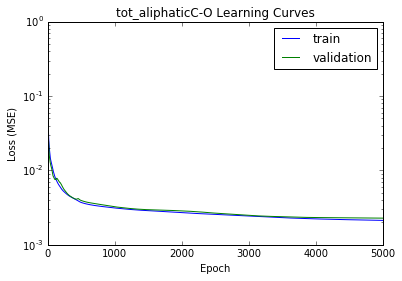

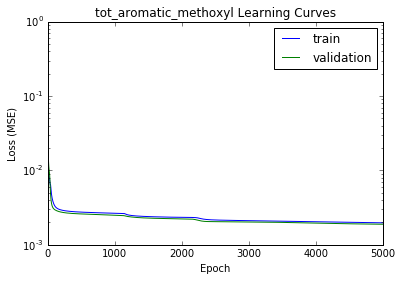

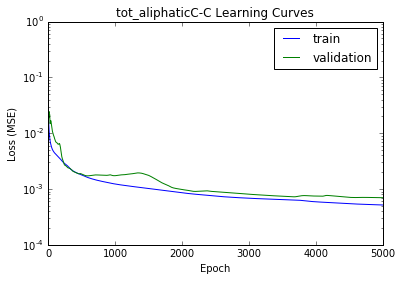

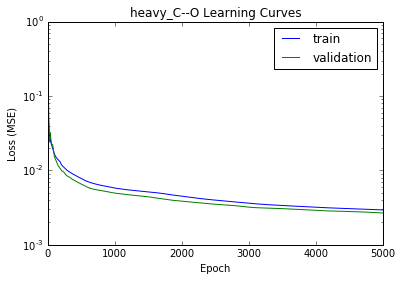

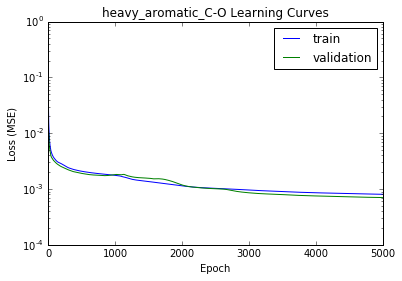

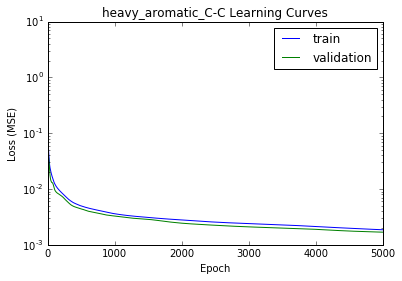

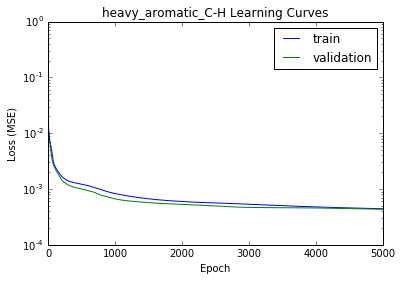

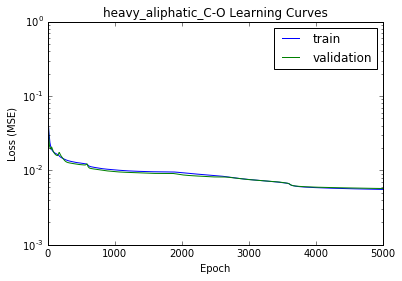

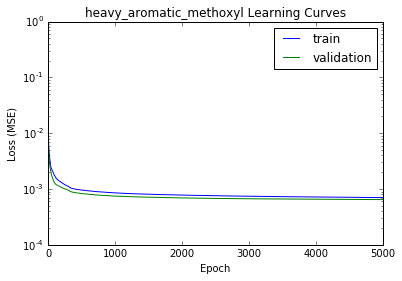

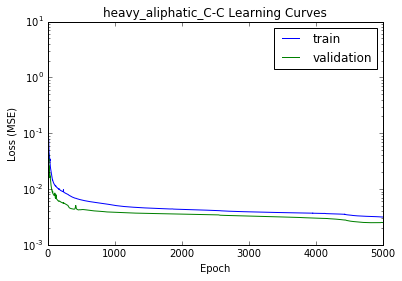

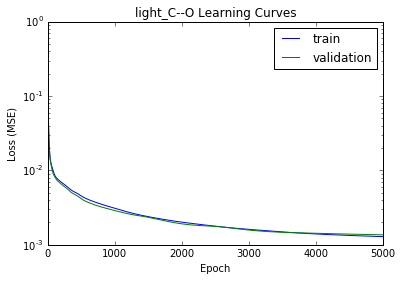

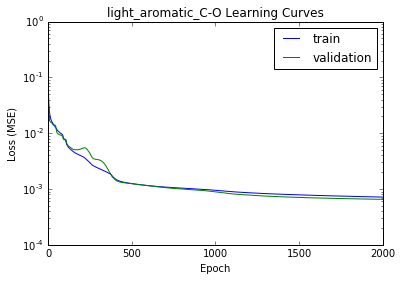

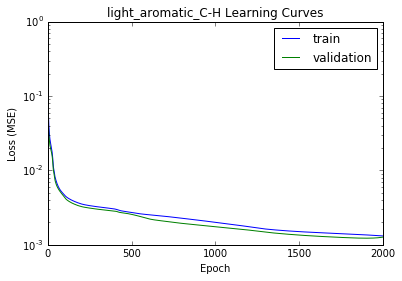

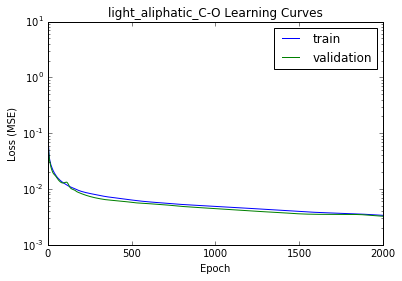

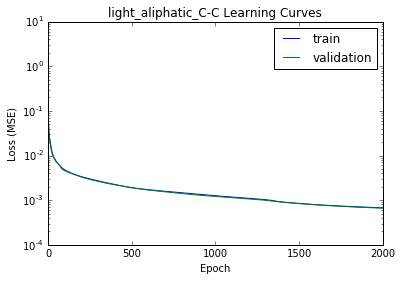

In [30]:
for key in nets:
    plot_one_learning_curve(key, nets)

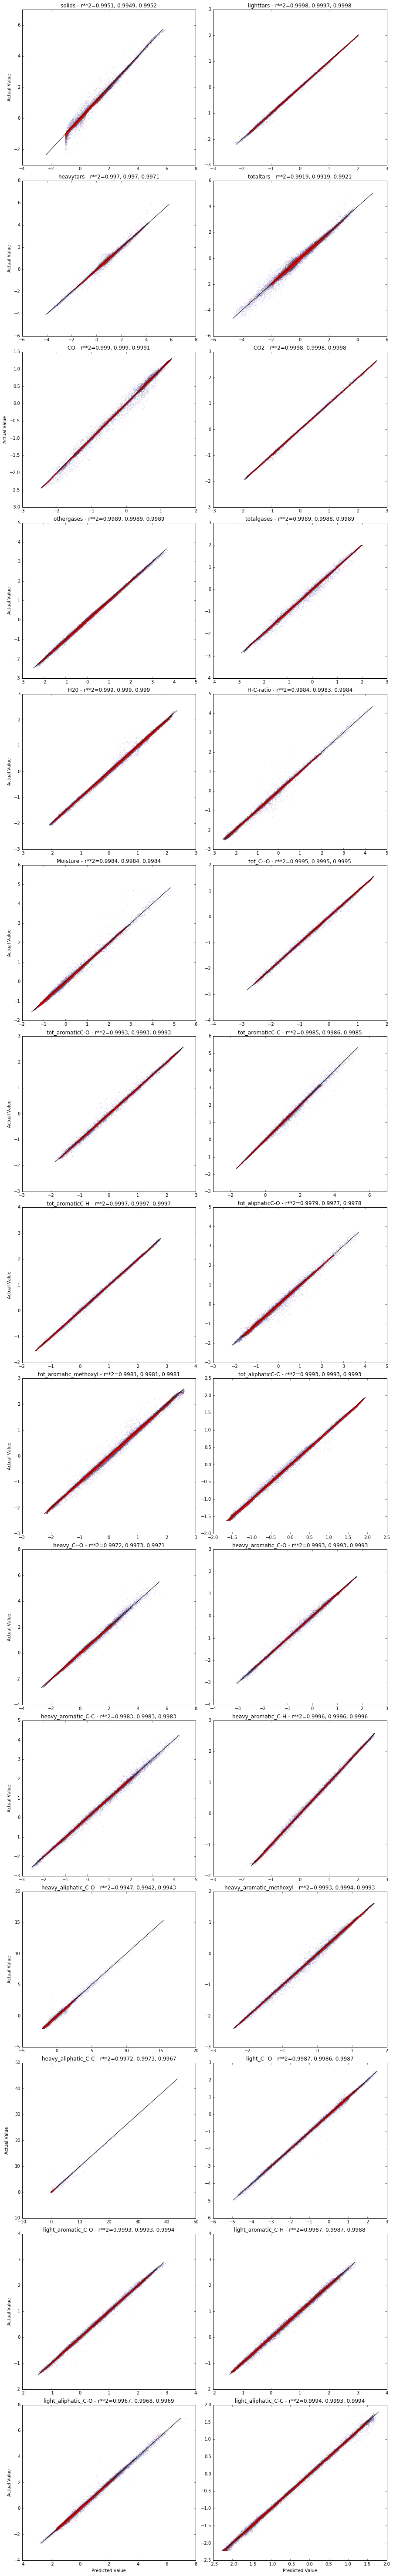

In [54]:
output_list = nets.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2, sharex=False,
                     sharey=False, figsize=(15, 3.5*len(output_list)))
ax = ax.ravel()

for key in output_list:
    title = Y_COLUMNS[key]
    net = nets[key]
    pplot_one_output(net, x_train, y_train, x_test, y_test, key, title)
    
ax[len(output_list)-1].set_xlabel('Predicted Value')
ax[len(output_list)-2].set_xlabel('Predicted Value')
# put y-labels on the left hand subplots
for i in range(0, len(output_list), 2):
    ax[i].set_ylabel('Actual Value')
f.subplots_adjust(hspace=0.1, wspace=0.1)
    

In [62]:
r_squared = calc_r_squared(nets, x_train, y_train)
keylist = r_squared.keys()
keylist.sort()
print 'R**2 values for training, validation, and test sets\n'
for x in keylist:
    print '%s:%s %s %s' % ('{: <28}'.format(x),
                           '{: >10}'.format(r_squared[x][0]),
                           '{: >10}'.format(r_squared[x][1]),
                           '{: >10}'.format(r_squared[x][2]))

R**2 values for training, validation, and test sets

CO                          :   0.99901    0.99901    0.99908
CO2                         :   0.99983    0.99984    0.99984
H-C-ratio                   :   0.99841    0.99833    0.99841
H20                         :     0.999    0.99904    0.99903
Moisture                    :   0.99835    0.99844    0.99838
heavy_C--O                  :   0.99718     0.9973    0.99712
heavy_aliphatic_C-C         :   0.99724    0.99727    0.99671
heavy_aliphatic_C-O         :   0.99467    0.99418    0.99431
heavy_aromatic_C-C          :   0.99828    0.99831    0.99825
heavy_aromatic_C-H          :   0.99957    0.99957    0.99955
heavy_aromatic_C-O          :   0.99925     0.9993    0.99927
heavy_aromatic_methoxyl     :   0.99934    0.99935    0.99934
heavytars                   :   0.99702    0.99703    0.99707
light_C--O                  :   0.99868    0.99864    0.99872
light_aliphatic_C-C         :   0.99938    0.99934    0.99938
light_aliphatic_C

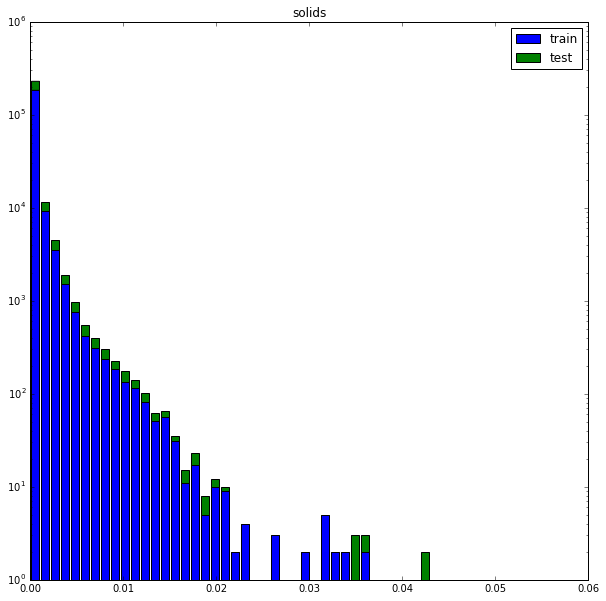

In [14]:
# Make a histogram for a specific output measure
output_col = 0
train_mse = []
net = net_objs[output_col]
y_predictions = net.predict(x_train)
for i, value in enumerate(y_train[:]):
    train_mse.append(mean_squared_error([y_train[i][output_col]],
                                        [y_predictions[i]]))
    
test_mse = []
y_predictions_test = net.predict(x_test)
for i, value in enumerate(y_test[:]):
    test_mse.append(mean_squared_error([y_test[i][output_col]],
                                       [y_predictions_test[i]]))

plt.figure(300, figsize=(10, 10))
plt.hist([train_mse, test_mse], bins=50, stacked=True, label=['train', 'test'],
         log=True)
plt.legend(loc=0)
plt.title('%s' % y_columns[output_col])


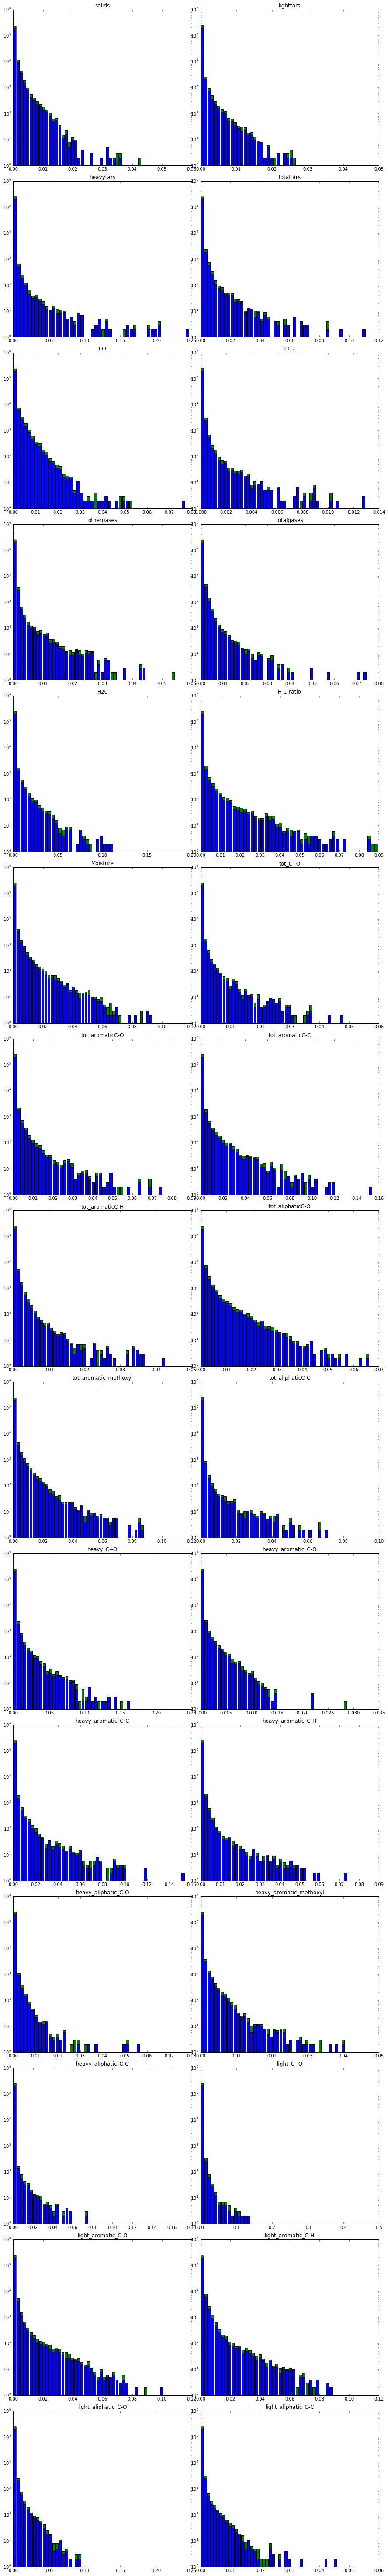

In [15]:
def hplot_one_output(y_train, y_test, y_predictions,
                     y_predictions_test, output_col):
    """
    Make a histogram for the training (blue) and test (green)
    MSEs of a specific output measure.
    
    Parameters
    ----------
    y_train            : numpy ndarray
                         The array with the training set values
    y_test             : numpy ndarray
                         The array with the test set values
    y_predictions      : numpy ndarray
                         The array with predictions for the training set values
    y_predictions_test : numpy ndarray
                         The array with predictions for the test set values
    output_col         : int
                         The column of the output measure you want to plot
    
    Returns
    -------
    None
    """
    train_mse = []
    for i, value in enumerate(y_train[:]):
        train_mse.append(mean_squared_error([y_train[i][output_col]],
                                            [y_predictions[i]]))

    test_mse = []
    for i, value in enumerate(y_test[:]):
        test_mse.append(mean_squared_error([y_test[i][output_col]],
                                           [y_predictions_test[i]]))

    ax[output_col].hist([train_mse, test_mse], bins=50, stacked=True,
                        label=['train', 'test'], log=True)
    ax[output_col].set_title('%s' % y_columns[output_col])


output_list = net_objs.keys()
f, ax = plt.subplots(int(round(len(output_list)/2.0)), 2,
                     figsize=(15, 3.5*len(output_list)))

ax = ax.ravel()
for key in net_objs:
    net = net_objs[key]
    y_predictions = net.predict(x_train)
    y_predictions_test = net.predict(x_test)
    hplot_one_output(y_train, y_test, y_predictions, y_predictions_test, key)
f.subplots_adjust(hspace=0.1, wspace=0.05)
    